# UMAP - Dimensionality Reduction and Classification

UMAP documentation: https://umap-learn.readthedocs.io/en/latest/

In [1]:
import numpy as np
import pandas as pd
import os
import math
# import seaborn as sns

import umap
from mnist.loader import MNIST

pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
# change font
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

import warnings
warnings.filterwarnings('ignore')

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

BORDER_WIDTH = 1
PIXEL_RESOLUTION = 255.0

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', linewidth=BORDER_WIDTH) # set width for plot border globally

## 1. Dimensionality Reduction: Embedding Fashion MNIST with UMAP

Reference code: https://umap-learn.readthedocs.io/en/latest/supervised.html

Fashion MNIST Dataset downloaded from https://www.kaggle.com/datasets/zalando-research/fashionmnist

In [3]:
mndata = MNIST(os.path.join(os.getcwd(), '..', 'data'))
train, train_labels = mndata.load_training()
test, test_labels = mndata.load_testing()
data = np.array(np.vstack([train, test]), dtype=np.float64) / PIXEL_RESOLUTION
target = np.hstack([train_labels, test_labels])

classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]
classes_dict = {k:v for k,v in zip(np.arange(len(classes)), classes)}

In [4]:
def plot_embedding_2D(embedding, target, title, classes_dict=classes_dict, figsize=(10, 7.5), marker_size=1):
    fig, ax = plt.subplots(1, figsize=figsize)
    plt.scatter(*embedding.T, s=marker_size**2, c=target, cmap='Spectral', alpha=1.0, linewidths=0)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(boundaries=np.arange(len(classes_dict)+1)-0.5)
    cbar.set_ticks(list(classes_dict.keys()))
    cbar.set_ticklabels(list(classes_dict.values()), fontsize=MEDIUM_SIZE)
    cbar.ax.tick_params(width=BORDER_WIDTH, length=5) 
    plt.title(title, fontsize=BIGGER_SIZE, pad=15)
    plt.show()

alternative plotting options: https://umap-learn.readthedocs.io/en/latest/plotting.html

In [5]:
N_COMPONENTS = 2 # 2D embedding
N_NEIGHBORS = 15 # UMAP hyperparameter (default=15): # of nearest neighbors to connect each data point to
SEED = 10 # random seed

### 1.1. Unsupervised UMAP

In [6]:
%%time
reducer = umap.UMAP(
    n_components=N_COMPONENTS, n_neighbors=N_NEIGHBORS,
    random_state=SEED, transform_seed=SEED, verbose=False
)
embedding_unsupervised = reducer.fit_transform(data)

CPU times: user 58 s, sys: 3.97 s, total: 1min 2s
Wall time: 38.4 s


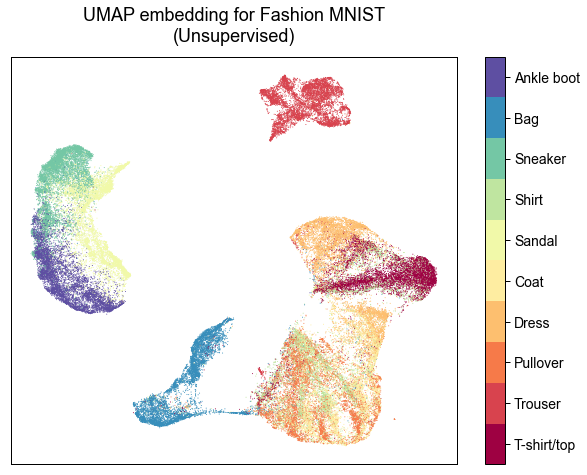

In [7]:
plot_embedding_2D(embedding_unsupervised, target,
                  title='UMAP embedding for Fashion MNIST\n(Unsupervised)')

### 1.2. Supervised UMAP

In [8]:
%%time
reducer = umap.UMAP(
    n_components=N_COMPONENTS, n_neighbors=N_NEIGHBORS,
    random_state=SEED, transform_seed=SEED, verbose=False
)
embedding_supervised = reducer.fit_transform(data, y=target)

CPU times: user 1min 17s, sys: 5.44 s, total: 1min 23s
Wall time: 40.9 s


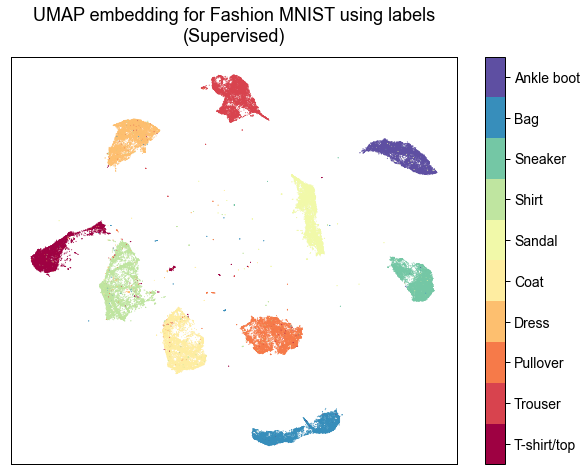

In [9]:
plot_embedding_2D(embedding_supervised, target,
                  title='UMAP embedding for Fashion MNIST using labels\n(Supervised)')

### 1.3. Semi-Supervised UMAP

In [10]:
# mask 20% of labels
masked_target = target.copy().astype(np.int8)
masked_target[np.random.choice(target.shape[0], size=target.shape[0]//5, replace=False)] = -1

In [11]:
%%time
reducer = umap.UMAP(
    n_components=N_COMPONENTS, n_neighbors=N_NEIGHBORS,
    random_state=SEED, transform_seed=SEED, verbose=False
)
embedding_semisupervised = reducer.fit_transform(data, y=masked_target)

CPU times: user 57.3 s, sys: 3.28 s, total: 1min
Wall time: 38.3 s


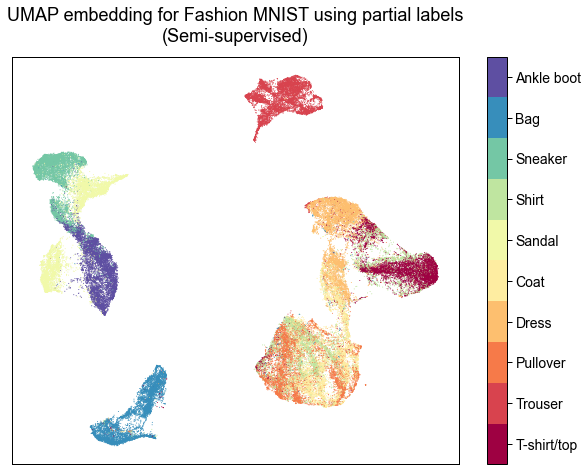

In [12]:
plot_embedding_2D(embedding_semisupervised, target,
                  title='UMAP embedding for Fashion MNIST using partial labels\n(Semi-supervised)')

## 2. Classifying Fashion MNIST with Supervised UMAP Embedding

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [14]:
# train, validation and test split

train_data = np.array(train, dtype=np.float64) / PIXEL_RESOLUTION
train_target = np.array(train_labels)

# Build balanced validation set from train set
X_train, X_val, y_train, y_val = train_test_split(train_data, train_target, test_size=1/6, stratify=train_target, random_state=SEED)

# Build test set
X_test = np.array(test, dtype=np.float64) / PIXEL_RESOLUTION
y_test = np.array(test_labels)

### Auxiliary functions

In [15]:
def get_centroids(embedding_, y_):
    components = ['x', 'y', 'z', 'i', 'j', 'k', 'u', 'v', 'w']
    df_embedding_ = pd.DataFrame(
        embedding_, columns=[components[i] for i in range(embedding_.shape[1])]
    )
    df_embedding_['true_label'] = y_
    df_centroids = df_embedding_.groupby('true_label').mean().sort_index()
    
    return df_centroids

In [16]:
def make_predictions(embedding_, df_centroids):
    # Each new point will be assigned the class of its closest cluster centroid.
    # A cluster is the set of points with the same class, and the centroid of the 
    # cluster is calculated by averaging the coordinates of the cluster's points.
    predictions = pd.DataFrame(embedding_, columns=df_centroids.columns).apply(
        lambda row: np.linalg.norm(row - df_centroids, axis=1).argmin(), axis=1
    )
    return predictions.values

In [17]:
def compute_metrics(y_test_, y_pred_, name=None):
    return pd.Series({
        'accuracy': accuracy_score(y_test_, y_pred_),
        'precision_macro': precision_score(y_test_, y_pred_, average='macro'),
        'precision_weighted': precision_score(y_test_, y_pred_, average='weighted'),
        'recall_macro': recall_score(y_test_, y_pred_, average='macro'),
        'recall_weighted': recall_score(y_test_, y_pred_, average='weighted'),
        'f1_macro': f1_score(y_test_, y_pred_, average='macro'),
        'f1_weighted': f1_score(y_test_, y_pred_, average='weighted')
    }, name=name)

In [18]:
def search_nn(search_space_nn, X_train, y_train, X_val, y_val, n_components):
    
    embeddings_val_dict = {}
    y_pred_dict = {}
    metrics_lst = []

    for nn in search_space_nn:
        classifier = umap.UMAP(
            n_components=n_components, n_neighbors=nn,
            random_state=SEED, transform_seed=SEED, verbose=False
        ).fit(X_train, y=y_train)

        df_centroids = get_centroids(classifier.embedding_, y_train)
        embeddings_val_dict[nn] = classifier.transform(X_val)
        y_pred_dict[nn] = make_predictions(embeddings_val_dict[nn], df_centroids)
        metrics_lst.append(compute_metrics(y_val, y_pred_dict[nn], name=nn))
    df_metrics = pd.concat(metrics_lst, axis=1).T
    
    return df_metrics, embeddings_val_dict

In [19]:
def plot_embeddings_search_2D(search_space_nn, y_val, embeddings_val_dict, df_metrics, title, classes_dict=classes_dict, marker_size=1.5):
    PLOTS_PER_ROW = 2
    n_rows = math.ceil(search_space_nn.shape[0]/PLOTS_PER_ROW)
    fig, axes = plt.subplots(n_rows, PLOTS_PER_ROW, figsize=(16, n_rows*5))
    i, j = 0, 0
    
    for n, nn in enumerate(search_space_nn):
        ax = axes[i][j]
        ax.scatter(*embeddings_val_dict[nn].T, s=marker_size**2, c=y_val, cmap='Spectral', alpha=1.0, linewidths=0)
        plt.setp(ax, xticks=[], yticks=[])
        cbar = plt.colorbar(mappable=ax.get_children()[0], boundaries=np.arange(len(classes_dict)+1)-0.5, ax=ax)
        cbar.set_ticks(list(classes_dict.keys()))
        cbar.set_ticklabels(list(classes_dict.values()), fontsize=MEDIUM_SIZE)
        cbar.ax.tick_params(width=BORDER_WIDTH, length=5) 
        ax.set_title(f"{n+1}) Nearest Neighbors: {nn}  |  Accuracy: {100*(df_metrics.loc[nn, 'accuracy']):.1f}%, F1 weighted: {(df_metrics.loc[nn, 'f1_weighted']):.3f}",
                          fontdict={'fontsize':MEDIUM_SIZE}, pad=15)
        j += 1
        if j % PLOTS_PER_ROW == 0:
            i += 1
            j = 0
            
    fig.suptitle(title, fontsize=BIGGER_SIZE, y=1.005)
    fig.tight_layout()
    fig.subplots_adjust(hspace=.2)
    plt.show()

In [20]:
def plot_embedding_3D(embedding, target, title, classes_dict=classes_dict, figsize=(12, 9), marker_size=1):
    fig, ax = plt.subplots(1, figsize=figsize, subplot_kw={'projection':'3d'})
    ax.scatter(*embedding.T, s=marker_size**2, c=target, cmap='Spectral', alpha=1.0, linewidths=0)
    plt.setp(ax, xticks=[], yticks=[], zticks=[])
    cbar = plt.colorbar(mappable=ax.get_children()[0], boundaries=np.arange(len(classes_dict)+1)-0.5)
    cbar.set_ticks(list(classes_dict.keys()))
    cbar.set_ticklabels(list(classes_dict.values()), fontsize=MEDIUM_SIZE)
    cbar.ax.tick_params(width=BORDER_WIDTH, length=5) 
    plt.title(title, fontsize=BIGGER_SIZE, pad=15)
    plt.show()
    
    
def plot_embeddings_search_3D(search_space_nn, y_val, embeddings_val_dict, df_metrics, title, classes_dict=classes_dict, marker_size=1.5):
    PLOTS_PER_ROW = 2
    n_rows = math.ceil(search_space_nn.shape[0]/PLOTS_PER_ROW)
    fig, axes = plt.subplots(n_rows, PLOTS_PER_ROW, figsize=(16, n_rows*6), subplot_kw={'projection':'3d'})
    i, j = 0, 0
    
    for n, nn in enumerate(search_space_nn):
        ax = axes[i][j]
        ax.scatter(*embeddings_val_dict[nn].T, s=marker_size**2, c=y_val, cmap='Spectral', alpha=1.0, linewidths=0)
        plt.setp(ax, xticks=[], yticks=[], zticks=[])
        cbar = plt.colorbar(mappable=ax.get_children()[0], boundaries=np.arange(len(classes_dict)+1)-0.5, ax=ax)
        cbar.set_ticks(list(classes_dict.keys()))
        cbar.set_ticklabels(list(classes_dict.values()), fontsize=MEDIUM_SIZE)
        cbar.ax.tick_params(width=BORDER_WIDTH, length=5) 
        ax.set_title(f"{n+1}) Nearest Neighbors: {nn}  |  Accuracy: {100*(df_metrics.loc[nn, 'accuracy']):.1f}%, F1 weighted: {(df_metrics.loc[nn, 'f1_weighted']):.3f}",
                          fontdict={'fontsize':MEDIUM_SIZE}, pad=15)
        j += 1
        if j % PLOTS_PER_ROW == 0:
            i += 1
            j = 0
            
    fig.suptitle(title, fontsize=BIGGER_SIZE, y=1.005)
    fig.tight_layout()
    fig.subplots_adjust(hspace=.2)
    plt.show()

In [21]:
def print_metrics(y_test_, y_pred_, print_classification_report=True, classes_dict=classes_dict):
    print('Final Model - Performance Metrics on Test Dataset:\n')
    print(f"Accuracy:           {accuracy_score(y_test_, y_pred_):.3f}\n")
    print(f"Precision macro:    {precision_score(y_test_, y_pred_, average='macro'):.3f}")
    print(f"Recall    macro:    {recall_score(y_test_, y_pred_, average='macro'):.3f}")
    print(f"F1 score  macro:    {f1_score(y_test_, y_pred_, average='macro'):.3f}\n")
    print(f"Precision weighted: {precision_score(y_test_, y_pred_, average='weighted'):.3f}")
    print(f"Recall    weighted: {recall_score(y_test_, y_pred_, average='weighted'):.3f} (= accuracy)")
    print(f"F1 score  weighted: {f1_score(y_test_, y_pred_, average='weighted'):.3f}\n")
    if print_classification_report == True:
        print('\nClassification Report: \n')
        print(classification_report(y_test_, y_pred_, target_names=classes_dict.values()))

In [22]:
def plot_search_metrics(df_metrics, title, figsize=(9, 6),
                        display_metrics=['accuracy', 'f1_weighted', 'f1_macro']):
    fig, ax = plt.subplots(1, figsize=figsize)
    for col in reversed(display_metrics):
        ax.plot(df_metrics.index, df_metrics[col], label=col, linewidth=2)
    ax.set_xscale('log')
    ax.minorticks_off()
    ax.set_xticks(search_space_nn, labels=search_space_nn)
    ax.grid(which='major', color='#CCCCCC', linestyle='--')
    ax.set_xlabel('Number of Nearest Neighbors')
    ax.set_title(title, fontsize=BIGGER_SIZE, pad=15)
    handles, labels = plt.gca().get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='lower right')
    plt.show()

In [23]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=BIGGER_SIZE, pad=20)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, ['\n'.join(name.rsplit(' ')) for name in target_names], rotation=30, fontsize=SMALL_SIZE)
        plt.yticks(tick_marks, ['\n'.join(name.rsplit(' ')) for name in target_names], fontsize=SMALL_SIZE)
        
    cm_copy = cm.copy()
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm_copy.max() / 1.5 if normalize else cm_copy.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.1f}%\n({})".format(cm[i, j]*100, cm_copy[i, j]),
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if cm_copy[i, j] > thresh else "black",
                     fontsize=SMALL_SIZE)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if cm_copy[i, j] > thresh else "black",
                     fontsize=SMALL_SIZE)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=MEDIUM_SIZE, labelpad=10)
    plt.xlabel('Predicted label\n\naccuracy={:.2f}%; misclassification={:.2f}%'.format(100*accuracy, 100*misclass), fontsize=MEDIUM_SIZE, labelpad=15)
    plt.show()

### 2.1. Nearest Neighbors hyperparameter search in 2D

In [24]:
search_space_nn = np.logspace(1, 8, num=8, endpoint=True, base=2, dtype=np.int) # 2, 4, 8, 16, ... 256
search_space_nn

array([  2,   4,   8,  16,  32,  64, 128, 256])

In [25]:
%%time
df_metrics_2D, embeddings_val_2D = search_nn(
    search_space_nn, X_train, y_train, X_val, y_val, n_components=2
)

CPU times: user 25min 17s, sys: 4min 42s, total: 29min 59s
Wall time: 11min 44s


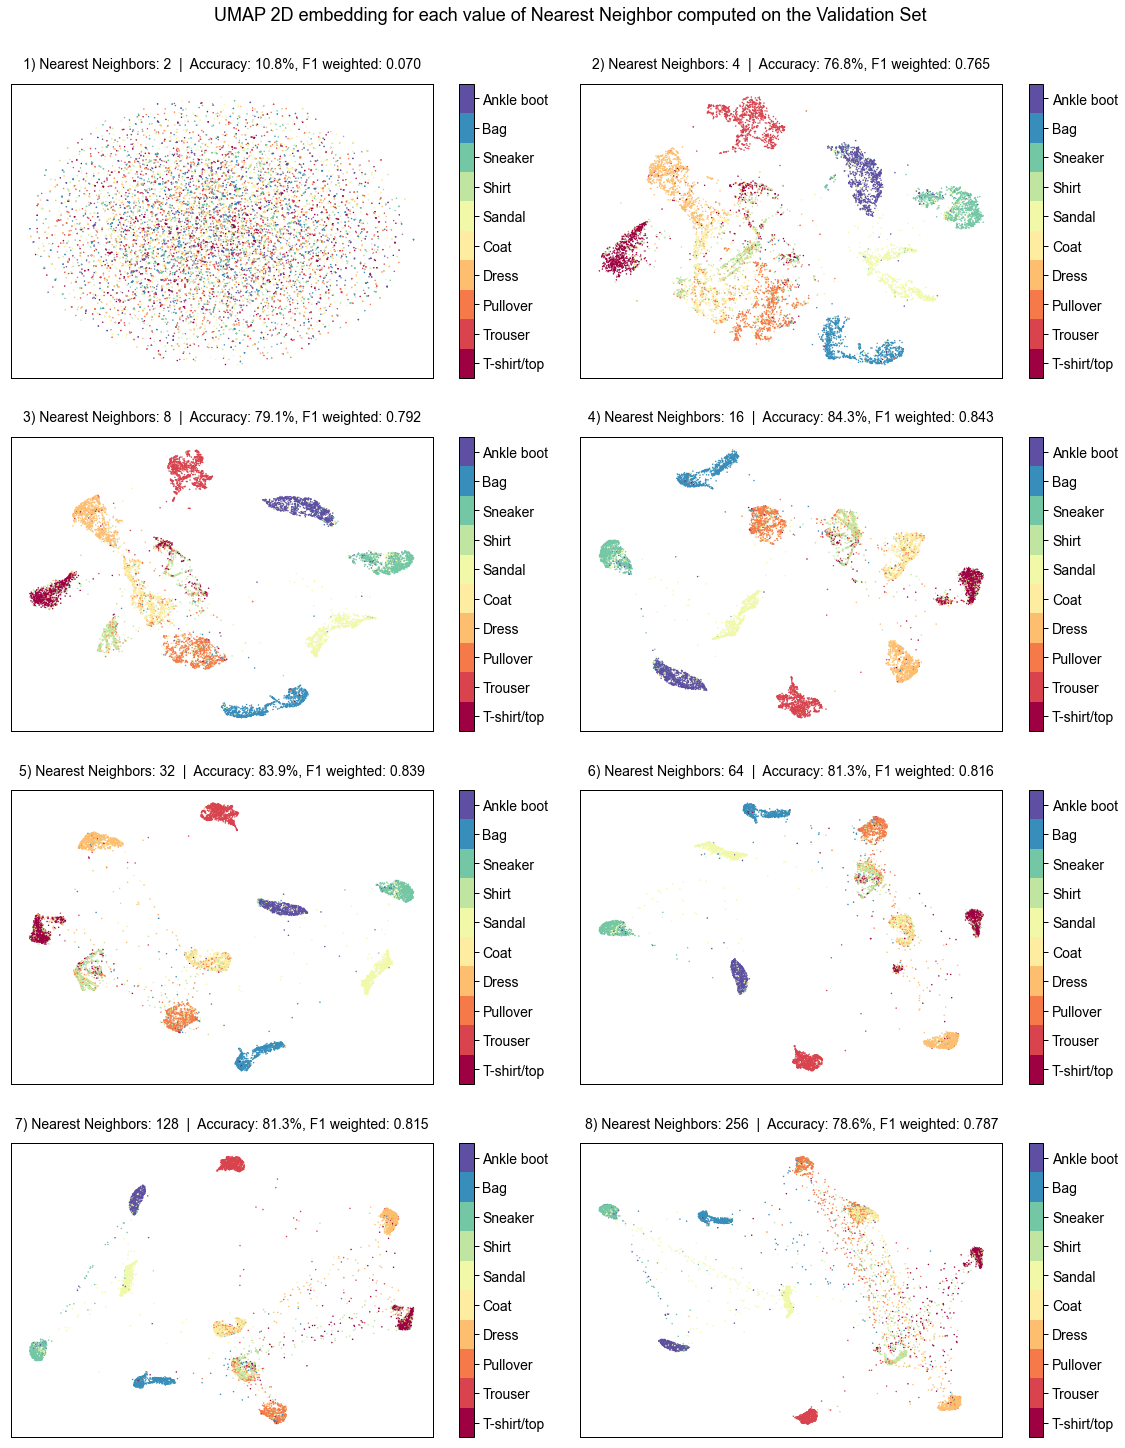

In [26]:
plot_embeddings_search_2D(search_space_nn, y_val, embeddings_val_2D, df_metrics_2D,
                          title='UMAP 2D embedding for each value of Nearest Neighbor computed on the Validation Set')

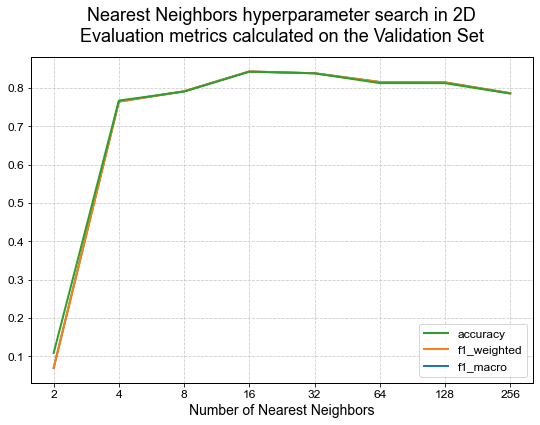

In [27]:
plot_search_metrics(
    df_metrics_2D, title=f'Nearest Neighbors hyperparameter search in 2D\nEvaluation metrics calculated on the Validation Set'
)

### 2.2. UMAP Classifier in 2D

In [28]:
n_neighbors_2D = df_metrics_2D['f1_weighted'].idxmax()
print(f'Best value for Nearest Neighbors in 2D: {n_neighbors_2D}')

Best value for Nearest Neighbors in 2D: 16


In [29]:
%%time
classifier_2D = umap.UMAP(
    n_components=2, n_neighbors=n_neighbors_2D,
    random_state=SEED, transform_seed=SEED, verbose=False
).fit(X_train, y=y_train)

embedding_train_2D = classifier_2D.embedding_
df_centroids_2D = get_centroids(embedding_train_2D, y_train)
embedding_test_2D = classifier_2D.transform(X_test)
y_pred_2D = make_predictions(embedding_test_2D, df_centroids_2D)

CPU times: user 59.3 s, sys: 6.65 s, total: 1min 5s
Wall time: 38.4 s


In [30]:
print_metrics(y_test, y_pred_2D, print_classification_report=False)

Final Model - Performance Metrics on Test Dataset:

Accuracy:           0.833

Precision macro:    0.840
Recall    macro:    0.833
F1 score  macro:    0.834

Precision weighted: 0.840
Recall    weighted: 0.833 (= accuracy)
F1 score  weighted: 0.834



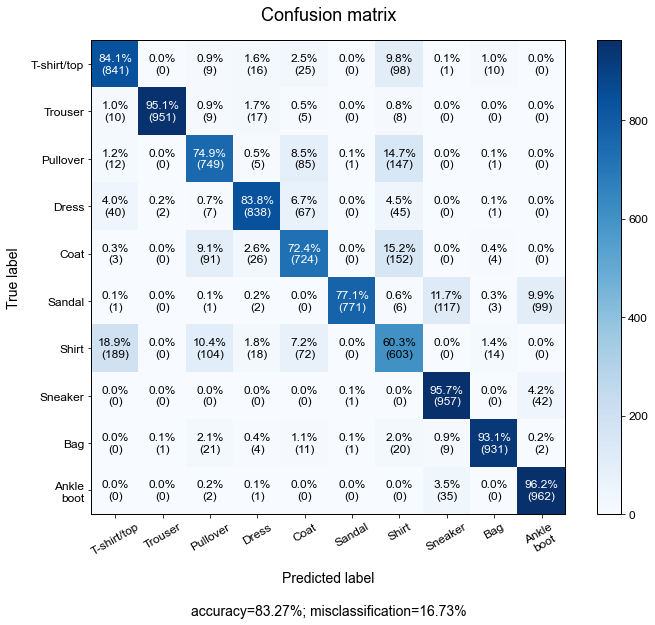

In [31]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_2D)
plot_confusion_matrix(cm, target_names=classes_dict.values())

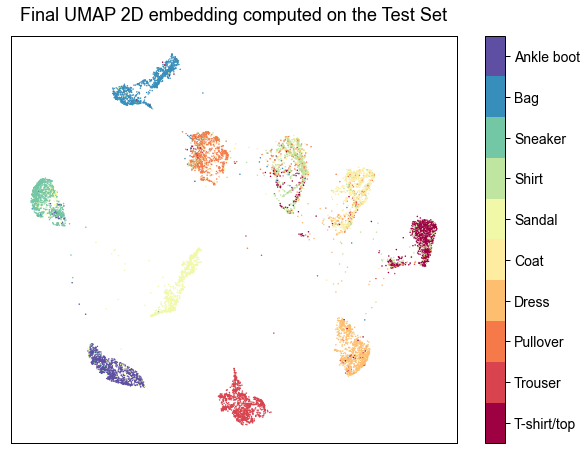

In [32]:
plot_embedding_2D(embedding_test_2D, y_test, marker_size=1.5,
                  title='Final UMAP 2D embedding computed on the Test Set')

### 2.3. Nearest Neighbors hyperparameter search in 3D

In [33]:
search_space_nn = np.logspace(1, 8, num=8, endpoint=True, base=2, dtype=np.int) # 2, 4, 8, 16, ... 256
search_space_nn

array([  2,   4,   8,  16,  32,  64, 128, 256])

In [34]:
%%time
df_metrics_3D, embeddings_val_3D = search_nn(
    search_space_nn, X_train, y_train, X_val, y_val, n_components=3
)

CPU times: user 24min, sys: 4min 2s, total: 28min 3s
Wall time: 12min 5s


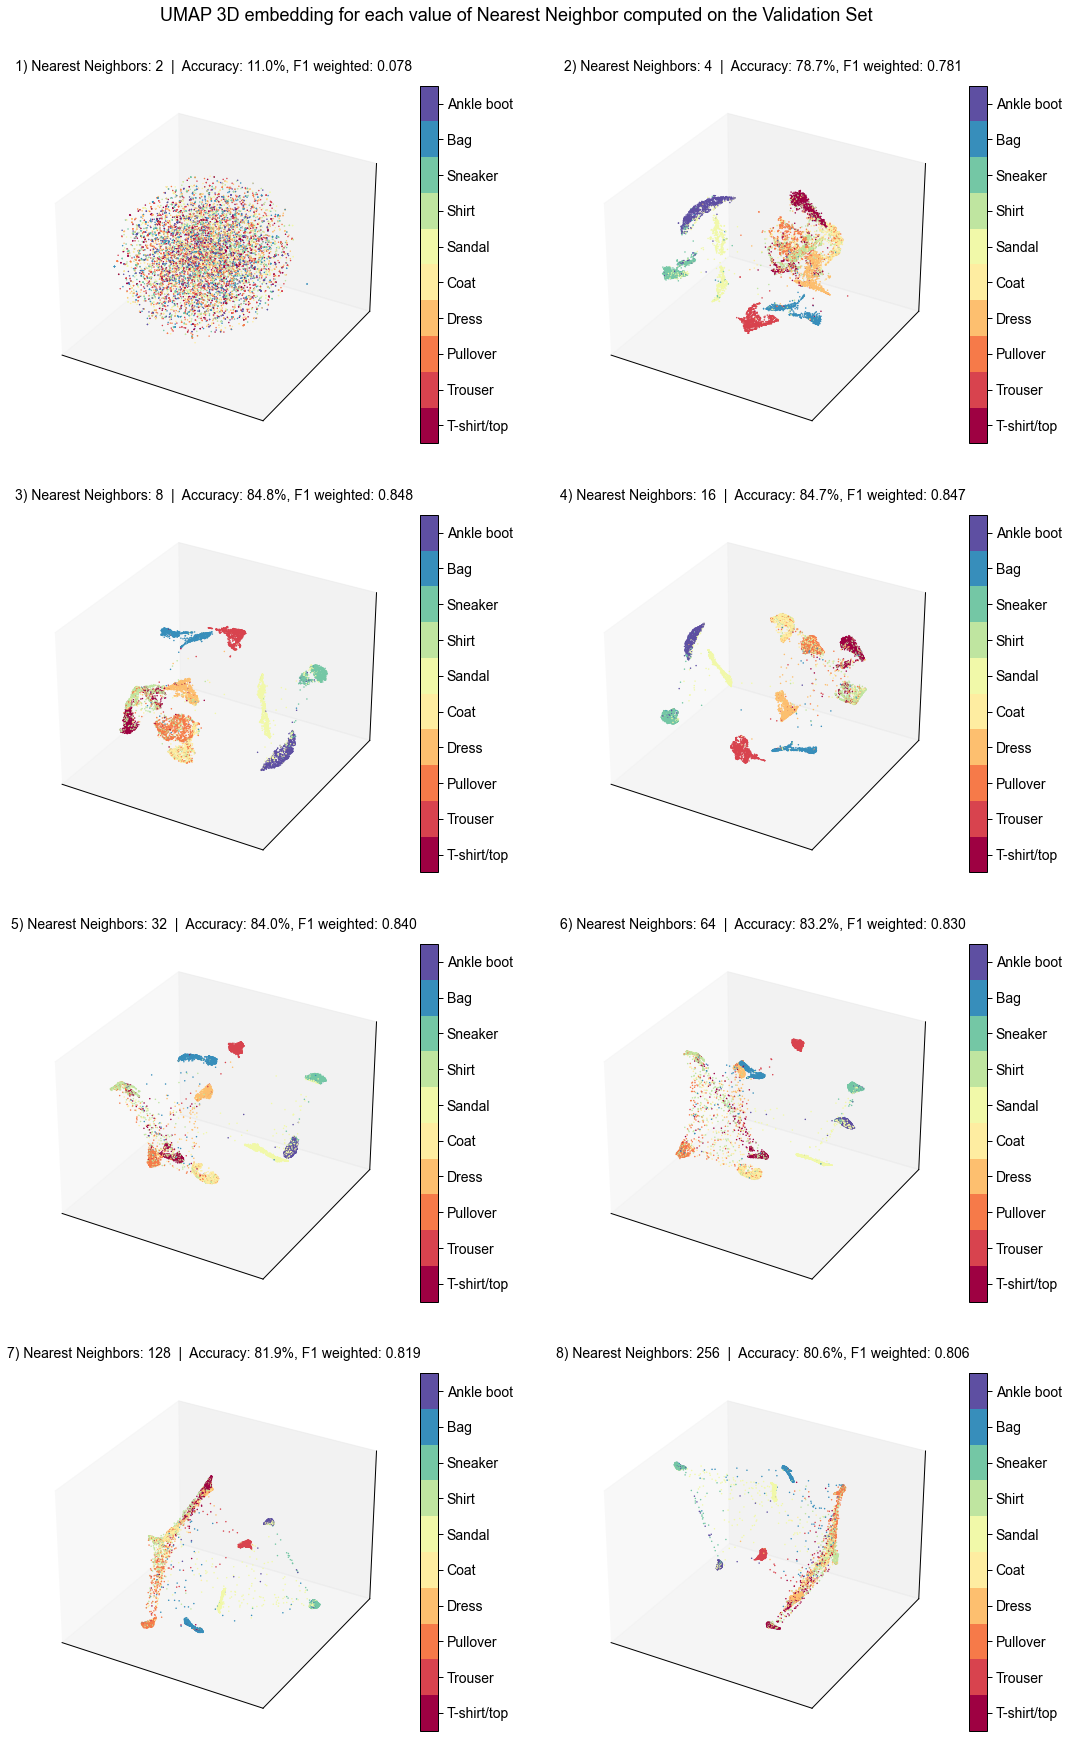

In [35]:
plot_embeddings_search_3D(search_space_nn, y_val, embeddings_val_3D, df_metrics_3D,
                          title='UMAP 3D embedding for each value of Nearest Neighbor computed on the Validation Set')

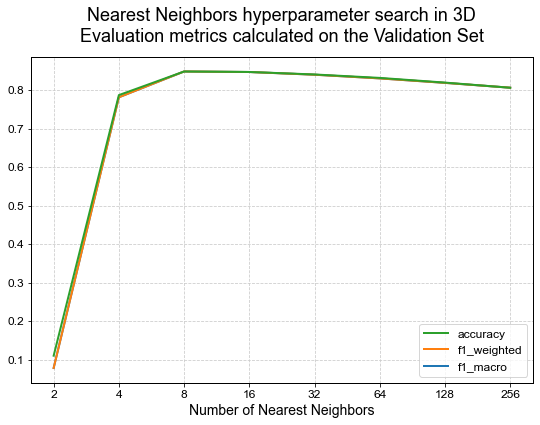

In [36]:
plot_search_metrics(
    df_metrics_3D, title=f'Nearest Neighbors hyperparameter search in 3D\nEvaluation metrics calculated on the Validation Set'
)

### 2.4. UMAP Classifier in 3D

In [37]:
n_neighbors_3D = df_metrics_3D['f1_weighted'].idxmax()
print(f'Best value for Nearest Neighbors in 2D: {n_neighbors_3D}')

Best value for Nearest Neighbors in 2D: 8


In [38]:
%%time
classifier_3D = umap.UMAP(
    n_components=3, n_neighbors=n_neighbors_3D,
    random_state=SEED, transform_seed=SEED, verbose=False
).fit(X_train, y=y_train)

embedding_train_3D = classifier_3D.embedding_
df_centroids_3D = get_centroids(embedding_train_3D, y_train)
embedding_test_3D = classifier_3D.transform(X_test)
y_pred_3D = make_predictions(embedding_test_3D, df_centroids_3D)

CPU times: user 46.6 s, sys: 4.04 s, total: 50.6 s
Wall time: 28.9 s


In [39]:
print_metrics(y_test, y_pred_3D, print_classification_report=False)

Final Model - Performance Metrics on Test Dataset:

Accuracy:           0.836

Precision macro:    0.842
Recall    macro:    0.836
F1 score  macro:    0.837

Precision weighted: 0.842
Recall    weighted: 0.836 (= accuracy)
F1 score  weighted: 0.837



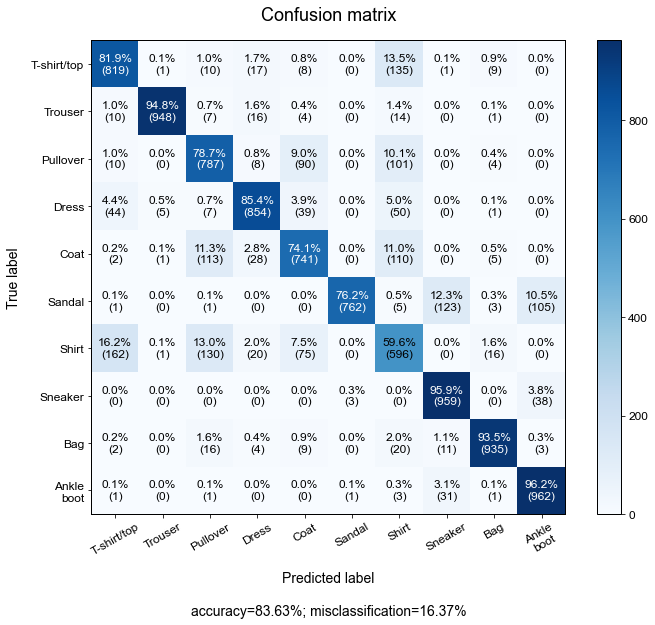

In [40]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_3D)
plot_confusion_matrix(cm, target_names=classes_dict.values())

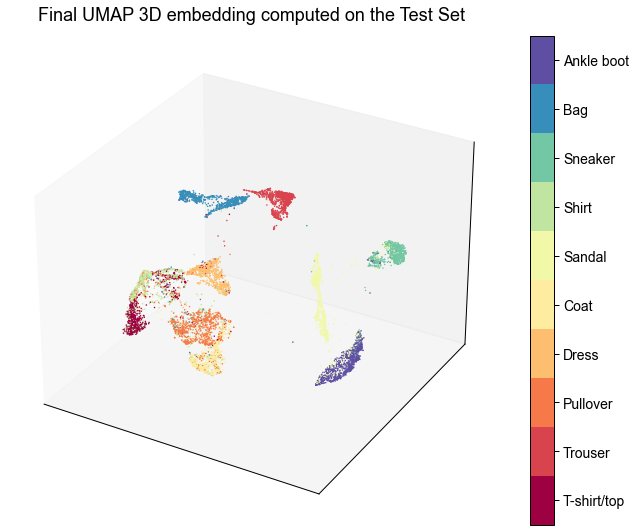

In [41]:
plot_embedding_3D(embedding_test_3D, y_test, marker_size=1.5,
                  title='Final UMAP 3D embedding computed on the Test Set')